## **Contents**
-  [Introduction](#i)
-  [1.Importing Libraries](#1)
-  [2.Helper Functions](#2)
-  [3.Dataset Managament](#3)
-  [4.Initializing pre-trained models](#4)
-  [5.Predictions](#5)
    -  [5.1.CRAFT](#5.1)
    -  [5.2.Faster R-CNN](#5.2)
    -  [5.3.IOU](#5.3)
    -  [5.4 Tesseract](#5.4)
    -  [5.5.Siamese Neural Network](#5.5)

## **Introduction** <a class="anchor" id="i"></a>

In this notebook, I am combining all the previous models to make a complete pipeline for an OCR which also classifies and links sentences.<br>

&nbsp;&nbsp;&nbsp;&nbsp;First, we are feeding the image of the scanned document into the CRAFT model which returns bounding boxes for sentences. Then we feed the image again into the Faster R-CNN model which we trained before which in return will give approximate regional bounding boxes of each label category. Now we will use the bounding boxes of each sentence and compare it with the regional bounding boxes that we got from Faster R-CNN using IOU and categorize each sentence that has maximum IOU score.<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;Now we will pass each sentence image into the Tesseract model which will give us bounding boxes of each word and translation for each word and sentence. Then we will iterate every two sentences and combine the predicted translation of each sentence with a bounding box and label classification feed into Siamese Neural Network which will give us a similarity score. We will use this similarity score to check against a threshold value and if it crosses the threshold then we will add it to the list of links for each sentence.

<img src= "OCR_flowchart.png" style='width: 1200px;'>

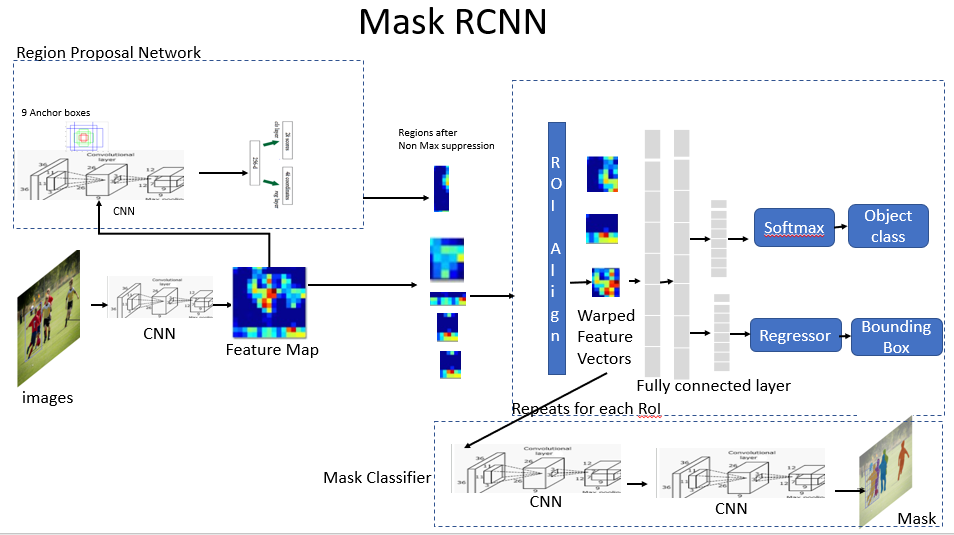

### **1.Importing Libraries** <a class="anchor" id="1"></a>

In [1]:
import cv2
import os
import re
import pytesseract
import torch
import torch.nn as nn
from word_Detection import *
import torch.nn.functional as F
import pickle
import torchvision
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torchvision.transforms as T
from pytesseract import Output
from word_Detection import *
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

### **2.Helper Functions** <a class="anchor" id="2"></a>

In [2]:
def IOU(box1, box2, screen_size=(480, 640)):  # calculating IOU
    boolean_box1 = np.zeros(screen_size, dtype=bool)
    boolean_box2 = np.zeros(screen_size, dtype=bool)

    x_min, y_min, x_max, y_max = box1
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

    for x in range(x_min, x_max):
        for y in range(y_min, y_max):
            boolean_box1[y][x] = True

    x_min, y_min, x_max, y_max = box2
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

    for x in range(x_min, x_max):
        for y in range(y_min, y_max):
            boolean_box2[y][x] = True

    overlap = boolean_box1 * boolean_box2  # Logical AND
    union = boolean_box1 + boolean_box2  # Logical OR

    return overlap.sum() / float(union.sum())

def padding(img,size):
    old_image_height, old_image_width, channels = img.shape
    new_image_width = size[0]
    new_image_height = size[1]
    color = (255,255,255)
    result = np.full((new_image_height,new_image_width, 3), color, dtype=np.uint8)

    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2

    # copy img image into center of result image
    result[y_center:y_center+old_image_height, 
           x_center:x_center+old_image_width] = img

    return result

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s
    
def tockenize(x_train,vocab=None):
    final_list_train = []
    for sent in x_train:
        for word in sent.lower().split():
            if preprocess_string(word) in vocab.keys():
                final_list_train.append([vocab[preprocess_string(word)]])
            try:
                float(word)
                final_list_train.append([1]) # digits are 1
            except ValueError:
                pass

    return np.array(final_list_train).reshape(1,-1)

def sentence_padding(sentences, seq_len):
    padded_sentences = []

    for sentence in sentences:
        sentence = np.array(sentence)
        size = sentence.shape[0]
        sentence = sentence.reshape((size,))
        if size >seq_len:
            padded_sentences.append(sentence[:seq_len])
        else:
            padding = np.zeros((seq_len-sentence.shape[0]))
            padded_sentences.append(np.append(padding,sentence))
            
    return np.array(padded_sentences).reshape((len(sentences),seq_len))

vocab = pickle.load(open("saved_models/vocab",'rb'))

### **3.Dataset Managament** <a class="anchor" id="3"></a>

#### 1.Initializing Dataset <a class="anchor" id="3.1"></a>

In [3]:
TEST_IMAGE_PATH = 'dataset/testing_data/images/'
TEST_ANNOTATION_PATH = 'dataset/testing_data/annotations/'

test_images_path = np.char.add(TEST_IMAGE_PATH,np.array(os.listdir(TEST_IMAGE_PATH)))
test_annotation_path = np.char.add(TEST_ANNOTATION_PATH,np.array(os.listdir(TEST_ANNOTATION_PATH)))

classes = []
for box in json.load(open(test_annotation_path[0]))['form']:
    if box['label'] not in classes:
        classes.append(box['label'])

print(classes,len(test_annotation_path))

['other', 'question', 'answer', 'header'] 50


### **4.Initializing pre-trained model** <a class="anchor" id="4"></a>

In [4]:
device = 'cpu'
model_sentence_detector = word_detector(True,"saved_models/craft_mlt_25k.pth","saved_models/craft_refiner_CTW1500.pth")

class siamese_multi_head(nn.Module):
    def __init__(self,device,hidden_size,n_layer,embedding_size):
        super().__init__()
        if 'embs_npa.npy' in os.listdir('saved_models/'):
            embs_npa = np.load('saved_models/embs_npa.npy')
        
        self.device = device
        self.n_layer = n_layer
        self.hidden_size = hidden_size

        # Sentence embeddings
        self.embedding_layer = nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float(),freeze=False)
        self.lstm_layer = nn.LSTM(embedding_size,hidden_size,n_layer,batch_first = True)

        #label layer
        self.label_l = nn.Linear(1,1)
        # combined
        self.l1 = nn.Linear(hidden_size+1+4,32)
        self.l2 = nn.Linear(32,1)

    def forward(self,x_words, x_labels, x_box):
        x_words_1 = self.embedding_layer(x_words[0])
        _ , (x_words_1,__) = self.lstm_layer(x_words_1)
        x_words_1 = F.relu(x_words_1[-1])

        x_words_2 = self.embedding_layer(x_words[1])
        _ , (x_words_2,__) = self.lstm_layer(x_words_2)
        x_words_2 = F.relu(x_words_2[-1])

        x_labels_1 = self.label_l(x_labels[0])
        x_labels_2 = self.label_l(x_labels[1])

        x_words = torch.abs(x_words_1-x_words_2)
        x_labels = torch.abs(x_labels_1-x_labels_2)
        x_box = torch.abs(x_box[0]-x_box[1])

        x = torch.cat([x_labels,x_box,x_words],dim=1)
        x = F.relu(self.l1(x))
        x = torch.sigmoid(self.l2(x))

        return x

similarity_model = siamese_multi_head('cpu',hidden_size = 64,n_layer= 2,embedding_size = 50).to(device)
similarity_model.load_state_dict(torch.load("saved_models/siamese_multi_head.pth",map_location=device))

model_sentence_detector = word_detector(True,"saved_models/craft_mlt_25k.pth","saved_models/craft_refiner_CTW1500.pth")

model_label_classifier = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = len(classes)+1
in_features = model_label_classifier.roi_heads.box_predictor.cls_score.in_features
model_label_classifier.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model_label_classifier.load_state_dict(torch.load(f'saved_models/faster_rcnn_sgd.pth'))
model_label_classifier.eval()

Loading weights from checkpoint (saved_models/craft_mlt_25k.pth)
Loading weights of refiner from checkpoint (saved_models/craft_refiner_CTW1500.pth)
Loading weights from checkpoint (saved_models/craft_mlt_25k.pth)
Loading weights of refiner from checkpoint (saved_models/craft_refiner_CTW1500.pth)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

### **5.Predictions**<a class="anchor" id="5"></a>

#### 1.CRAFT <a class="anchor" id="5.1"></a>

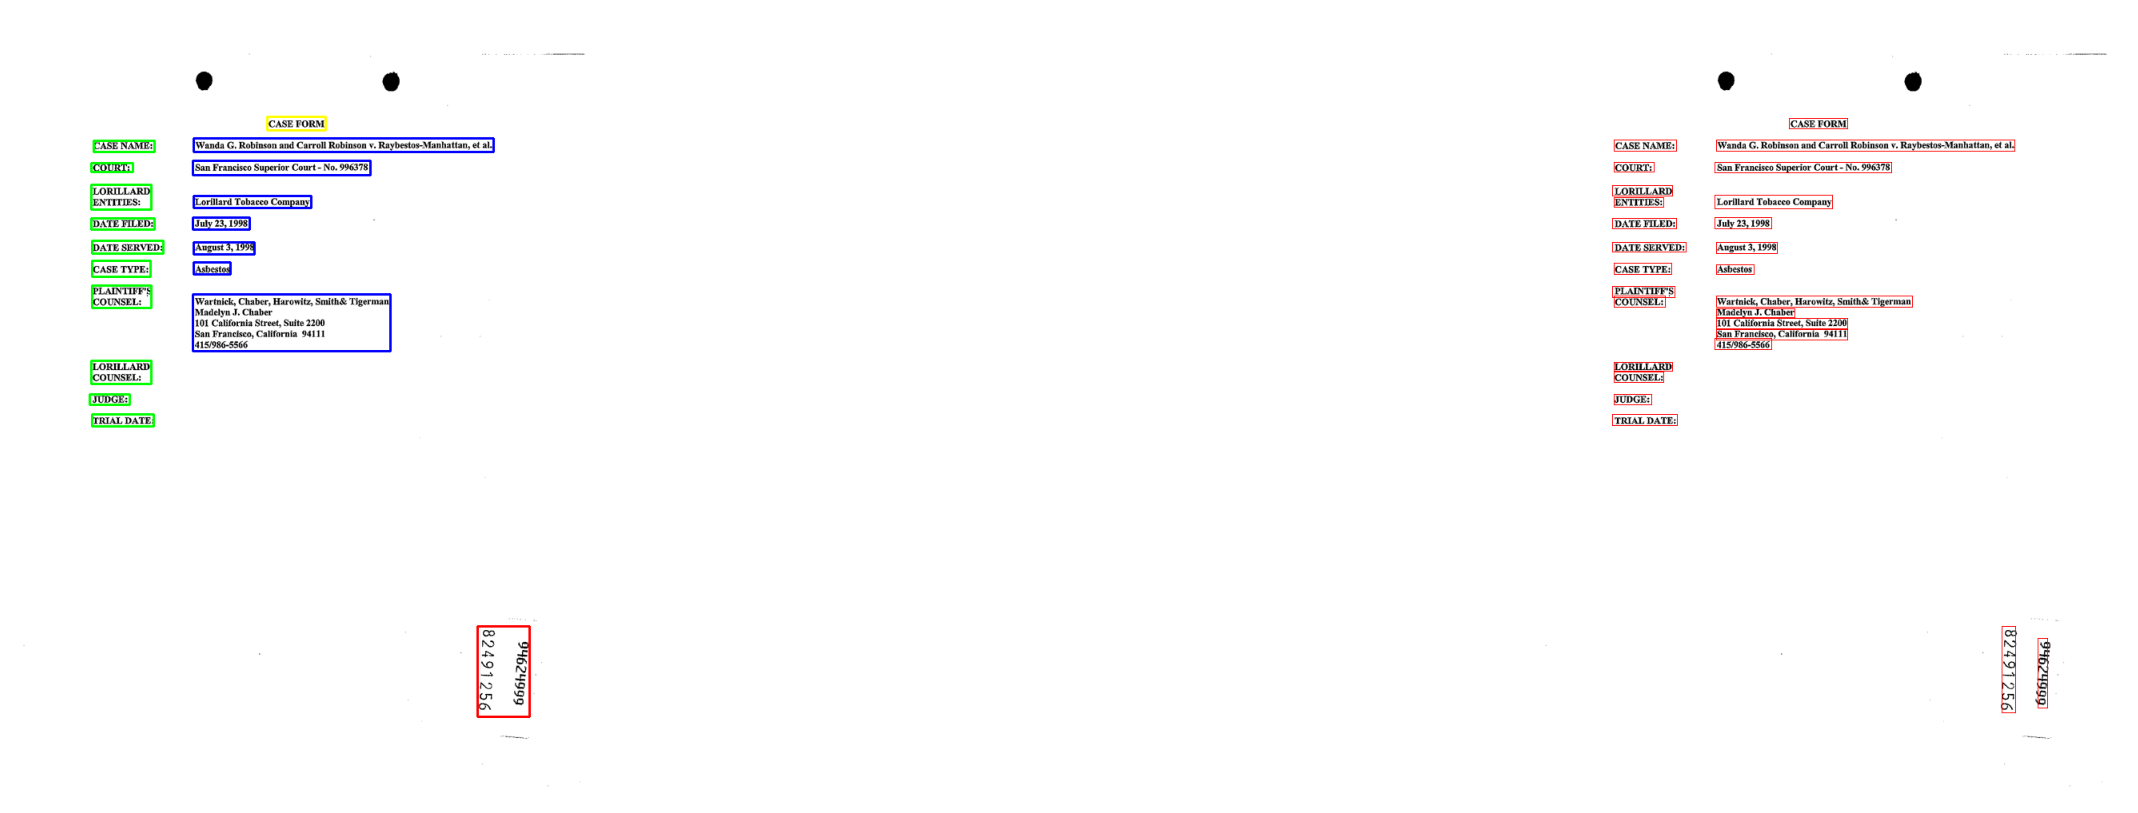

In [5]:
n = 9
img = cv2.imread(test_images_path[n])

plt.figure(figsize=(50,50))

form = json.load(open(test_annotation_path[n]))['form']
colors = cm.rainbow(np.linspace(0, 1, len(form)))

color_code = {1:(255,0,0),2:(0,255,0),3:(0,0,255),4:(255,255,0)}

for i in form:
    thickness = 2
    bounding_vertex = tuple(i['box'])
    x_min, y_min, x_max, y_max = bounding_vertex
    img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color_code[classes.index(i['label'])+1], thickness )

plt.subplot(3, 2, 1)
plt.axis('off')
plt.imshow(img)

img = cv2.imread(test_images_path[n])
boxxes, _ = model_sentence_detector.detect(test_images_path[n])
boxxes = boxxes.astype(np.int32)

color = (255, 0, 0, 0)
for box in boxxes:
    thickness = 1
    x_min, y_min = tuple(box[0])
    x_max, y_max = tuple(box[2])
    img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness )

plt.subplot(3, 2, 2)
plt.axis('off')
plt.imshow(img)
plt.show()

#### 2.Faster R-CNN <a class="anchor" id="5.1"></a>

C:\Python\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


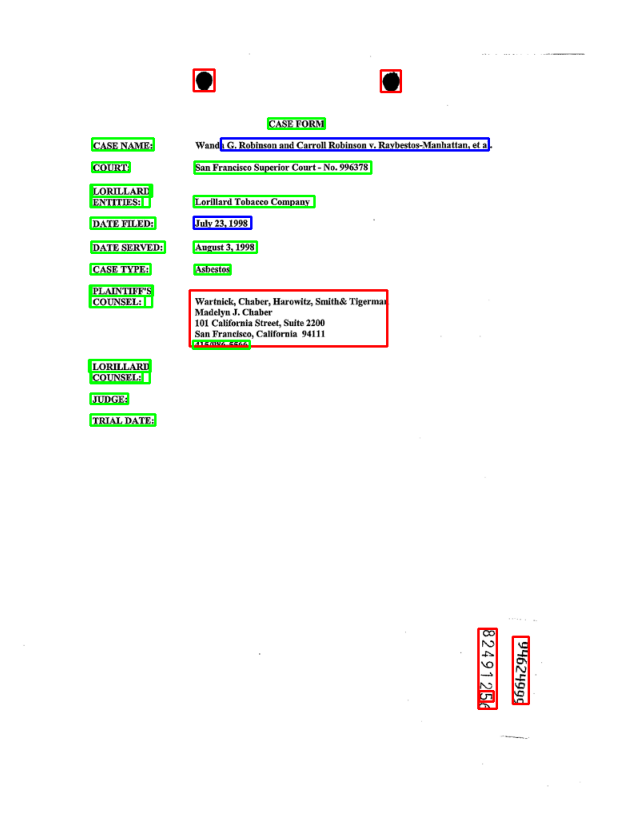

In [6]:
img = cv2.imread(test_images_path[n])
device = 'cpu'
color_code = {1:(255,0,0),2:(0,255,0),3:(0,0,255),4:(255,255,0)}
transforms = T.Compose([T.ToTensor()])
transformed_input = {}

input_img = transforms(img).unsqueeze(0)
prediction = model_label_classifier(input_img)[0]

for (box, scores, label_n) in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
    box = box.detach().numpy().astype(np.int32)
    scores = scores.detach().numpy()
    label_n = label_n.detach().numpy()
    if scores<=0.50:
        continue
    cv2.rectangle(img,(box[0], box[1]),(box[2], box[3]),color_code[int(label_n)],2)

plt.figure(figsize=(50,50))  
plt.subplot(3, 2, 2)
plt.imshow(img)
plt.axis('off')
plt.show()

#### 3.IOU <a class="anchor" id="5.3"></a>

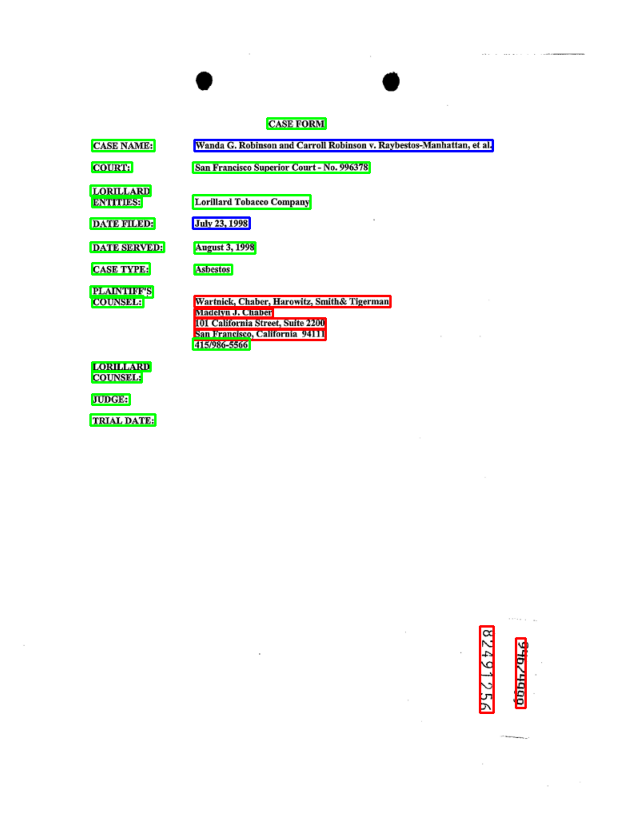

In [7]:
img = cv2.imread(test_images_path[n])
shape = img.shape[:2]
iou_label = []
for  bounding_boxes in boxxes:
    iou_label.append(1)  # 1 for others
    temp_iou = 0
    x_min, y_min = tuple(bounding_boxes[0])
    x_max, y_max = tuple(bounding_boxes[2])

    for labels, label_boxes, scores in zip(prediction['labels'], prediction['boxes'], prediction['scores']):
        scores = scores.detach().numpy()
        if scores<0.5:
            continue
        labels = labels.detach().numpy()
        label_boxes = label_boxes.detach().numpy().astype(np.int32)   
        iou = IOU([label_boxes[0], label_boxes[1], label_boxes[2], label_boxes[3]],[x_min, y_min, x_max, y_max],shape)    # xmin y min xmax y max
        if iou>temp_iou:
            temp_iou = iou
            iou_label[-1] = int(labels)


plt.figure(figsize=(50,50))
for box,each_label in zip(boxxes, iou_label):
    thickness = 2
    x_min, y_min = tuple(box[0])
    x_max, y_max = tuple(box[2])
    img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color_code[each_label], thickness )

plt.subplot(3, 2, 2)
plt.axis('off')
plt.imshow(img)

#### 4.Tesseract <a class="anchor" id="5.4"></a>

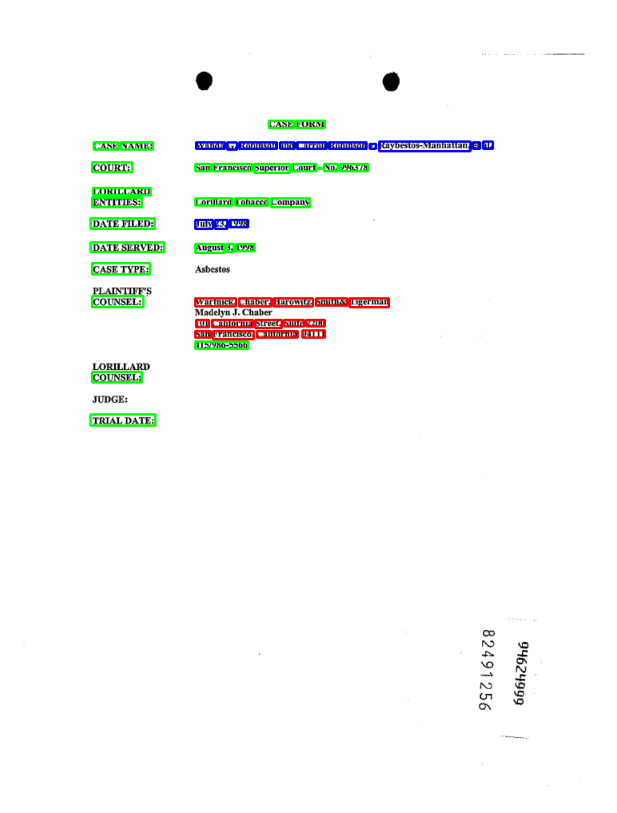

In [8]:
img = cv2.imread(test_images_path[n])
output_img =  np.copy(img)
each_sentence = []
each_word = []
each_word_coord = []

for  bounding_boxes, each_label in zip(boxxes, iou_label):
    x_min, y_min = tuple(bounding_boxes[0])
    x_max, y_max = tuple(bounding_boxes[2])

    strip_img = img[y_min:y_max,x_min:x_max]
    h, w, c = strip_img.shape
    each_sentence.append(pytesseract.image_to_string(strip_img))
    d = pytesseract.image_to_data(strip_img, output_type=Output.DICT)
    n_boxes = len(d['text'])

    temp_each_word_coord = []
    temp_each_word = []
    for i in range(n_boxes):
        if float(d['conf'][i]) > 0:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            if w == 0 or h == 0:
                continue
            temp_each_word_coord.append([(x_min+x, y_min+y), (x_min+x + w, y_min+y + h)])
            output_img = cv2.rectangle(output_img, (x_min+x, y_min+y), (x_min+x + w, y_min+y + h), color_code[each_label], 2)
            temp_each_word.append(pytesseract.image_to_string(padding(img[y_min+y:y_min+y+h, x_min+x:x_min+x+w],img.shape[:2])))

    each_word_coord.append(temp_each_word_coord)
    each_word.append(temp_each_word)

plt.figure(figsize=(50,50))
plt.subplot(3, 2, 1)
plt.axis('off')
plt.imshow(output_img)

In [9]:
for idx, (whole, sep) in enumerate(zip(each_sentence,each_word)):
    for w_idx,word in enumerate(sep):
        each_word[idx][w_idx] = word.strip()
        print(word.strip(),end=" ")

    print(f" :------: {whole.strip()}")
    each_sentence[idx] = each_sentence[idx].strip()
    if whole.strip() == "":
        each_sentence[idx] = " ".join(each_word[idx])
        

CASE FORM  :------: CASE FORM
 NAME:  :------: CASE NAME:
Wanda  Robinson  Careolt Robinson  Raybestos-Manhattan, et   :------: Wanda G. Robinson and Carroll Robinson y. Raybestos-Manhattan, et al.
court:  :------: 
 Francisco Superior Court   996378  :------: San Francisco Superior Court - No, 996378
‘LORILLARD  :------: LORILLARD
Lorillard Tobacco Company  :------: Lorillard Tobacco Company
ENTITIES:  :------: 
July 23, 1998  :------: July 23, 1998
DATE FILED:  :------: 
DATE SERVED:  :------: 
August 3 1998  :------: August 3, 1998
CASE TYPE:  :------: 
 :------: 
 :------: 
Wartniek, Chaber, Harowitz, Smiths ‘german  :------: ‘Chaber, Harowitz, Smith& Tigerman
COUNSEL:  :------: 
 :------: 
101 California Street, Suite 2200  :------: 101 California Street, Suite 2200
San Francisco, California gait  :------: San Francisco, California 94111
415/986-5866  :------: 415/986-5566
 :------: 
‘COUNSEL:  :------: 
 :------: 
‘TRIAL DATE:  :------: 
 :------: 
 :------: 


#### 4.Siamese Neural Network <a class="anchor" id="5.4"></a>

In [10]:
linked_dict = {}

for ref1 , (sentence1, sentence_coord1,label1) in enumerate(zip(each_sentence,boxxes,iou_label)):
    if ref1 not in linked_dict.keys():
        linked_dict[ref1] = []

    sentence1 = torch.LongTensor(sentence_padding(tockenize([sentence1],vocab=vocab),seq_len=50))
    
    sentence_coord1 = torch.FloatTensor([[sentence_coord1[0][0],sentence_coord1[0][1],sentence_coord1[2][0],sentence_coord1[2][1]]])
    label1 = torch.FloatTensor([label1]).unsqueeze(0)

    for ref2 , (sentence2, sentence_coord2,label2) in enumerate(zip(each_sentence,boxxes,iou_label)):
        if ref2 == ref1:
            continue
        if ref2 not in linked_dict.keys():
            linked_dict[ref2] = []

        sentence2 = torch.LongTensor(sentence_padding(tockenize([sentence2],vocab=vocab),seq_len=50))
        sentence_coord2 = torch.FloatTensor([[sentence_coord2[0][0],sentence_coord2[0][1],sentence_coord2[2][0],sentence_coord2[2][1]]])
        label2 = torch.FloatTensor([label2]).unsqueeze(0)
        similarity = float(similarity_model([sentence1,sentence2],[label1,label2],[sentence_coord1,sentence_coord2]).detach().numpy()[0])
        if similarity>=0.5:
            if ref2 not in linked_dict[ref1]:
                linked_dict[ref1].append(ref2)

            if ref1 not in linked_dict[ref2]:
                linked_dict[ref2].append(ref1)


print(linked_dict)

{0: [2], 1: [2], 2: [0, 1, 3, 4, 15], 3: [2, 4], 4: [2, 3, 15], 5: [7], 6: [7, 8, 17, 18, 19], 7: [5, 6, 10], 8: [6, 9, 10, 11, 13, 15, 17, 18, 19, 20], 9: [8, 10], 10: [7, 8, 9, 11, 12, 14], 11: [8, 10, 17], 12: [10, 15], 13: [8, 15, 17, 19], 14: [10, 15, 16], 15: [2, 4, 8, 12, 13, 14, 16, 17, 20], 16: [14, 15, 17, 18], 17: [6, 8, 11, 13, 15, 16, 18, 20], 18: [6, 8, 16, 17, 19, 20], 19: [6, 8, 13, 18, 20], 20: [8, 15, 17, 18, 19], 21: [22], 22: [21], 23: [24], 24: [23], 25: [], 26: []}
